In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import warnings
warnings.filterwarnings("ignore")

In [2]:
os.chdir(r'C:\Users\yusuf\Desktop\Portfolio')

In [3]:
print("Current working directory:", os.getcwd())
print("Contents of the directory:", os.listdir())

Current working directory: C:\Users\yusuf\Desktop\Portfolio
Contents of the directory: ['.ipynb_checkpoints', 'cleaned_fitness_data.csv', 'cleaned_heart_health.csv', 'DataCleaningPreprocessing.ipynb', 'EDA Fitness Data.ipynb', 'fitness_data.csv', 'fitness_tracker.csv', 'Heart_health.csv', 'lung_cancer_data.csv', 'TimeSeriesAnalysis.ipynb']


In [4]:
df = pd.read_csv('fitness_tracker.csv')

In [5]:
print("Initial Data Overview:")
print(df.head())
print("\nDataset Information:")
df.info()

Initial Data Overview:
         date  steps  distance  runDistance  calories
0  2016-04-27   4948      3242           46       281
1  2016-04-28  16573     12060           79       751
2  2016-04-29  18002     12916           29       737
3  2016-04-30   4126      2981           11       207
4  2016-05-01   3869      2651            0       244

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2454 entries, 0 to 2453
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         2454 non-null   object
 1   steps        2454 non-null   int64 
 2   distance     2454 non-null   int64 
 3   runDistance  2454 non-null   int64 
 4   calories     2454 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 96.0+ KB


In [6]:
df.columns = df.columns.str.lower()

In [7]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
date           0
steps          0
distance       0
rundistance    0
calories       0
dtype: int64


In [8]:
df.fillna(method='ffill', inplace=True)

In [9]:
df['date'] = pd.to_datetime(df['date'])

In [10]:
df.set_index('date', inplace=True)

In [11]:
df = df.asfreq('D')

In [23]:
print("\nData After Preprocessing:")
print(df.head())


Data After Preprocessing:
            steps  distance  rundistance  calories
date                                              
2016-04-27   4948      3242           46       281
2016-04-28  16573     12060           79       751
2016-04-29  18002     12916           29       737
2016-04-30   4126      2981           11       207
2016-05-01   3869      2651            0       244


### Identify Trends and Seasonality

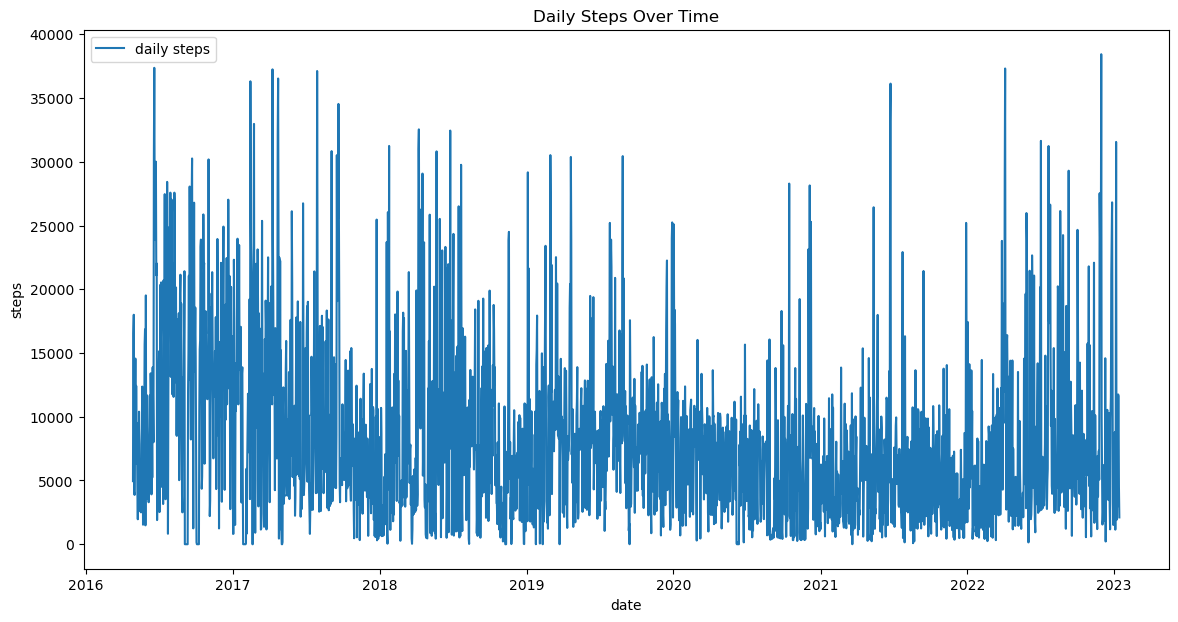

In [25]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['steps'], label='daily steps')
plt.title('Daily Steps Over Time')
plt.xlabel('date')
plt.ylabel('steps')
plt.legend()
plt.show()

In [26]:
decomposition = seasonal_decompose(df['steps'], model='additive')

In [27]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

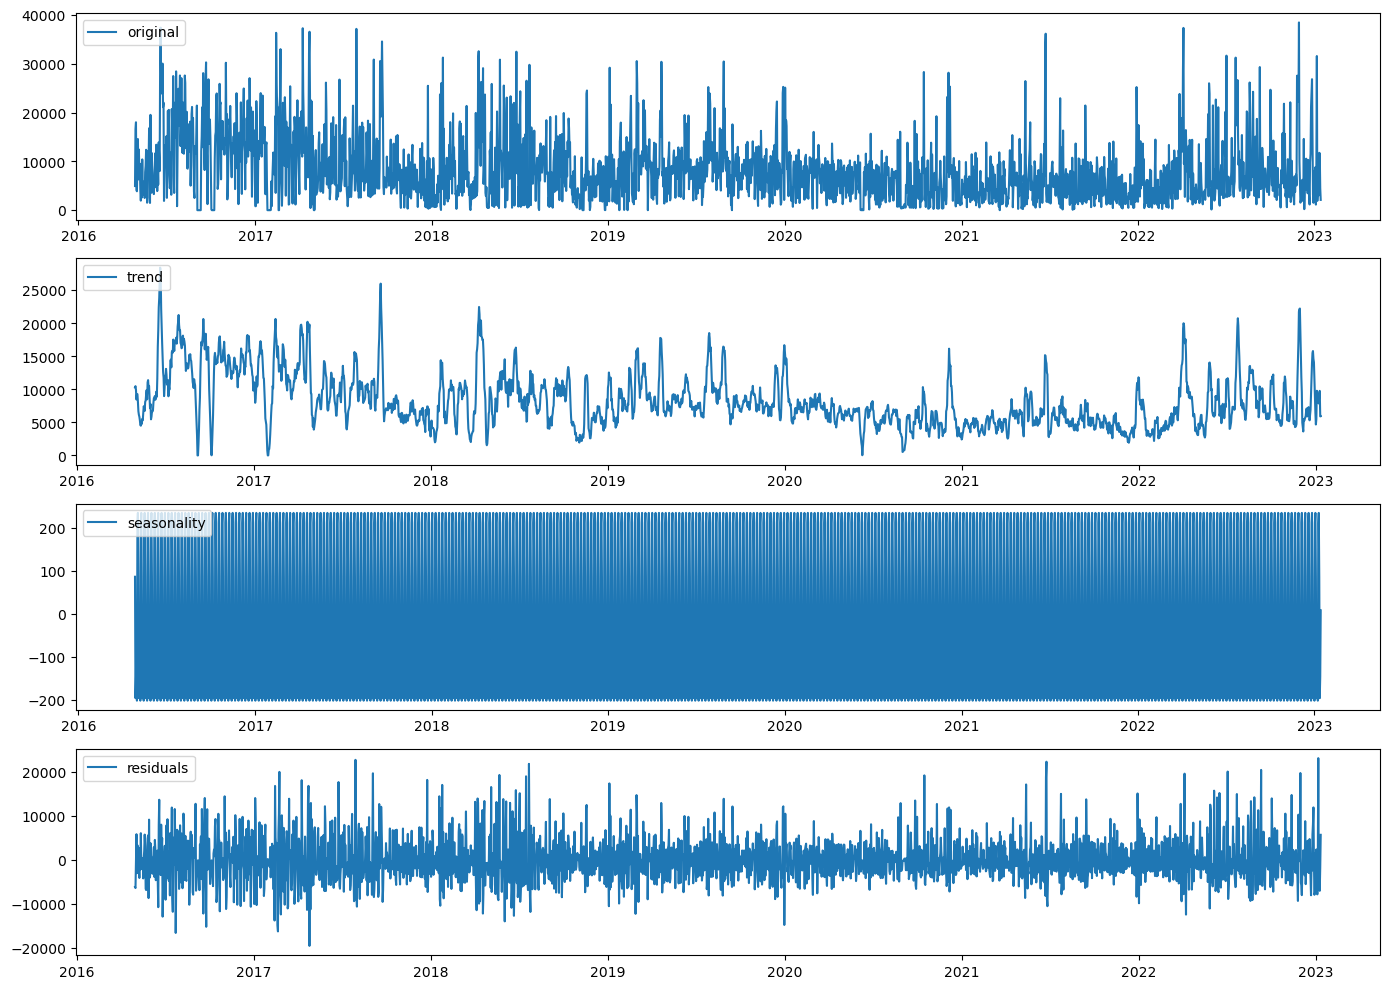

In [31]:
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(df['steps'], label='original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

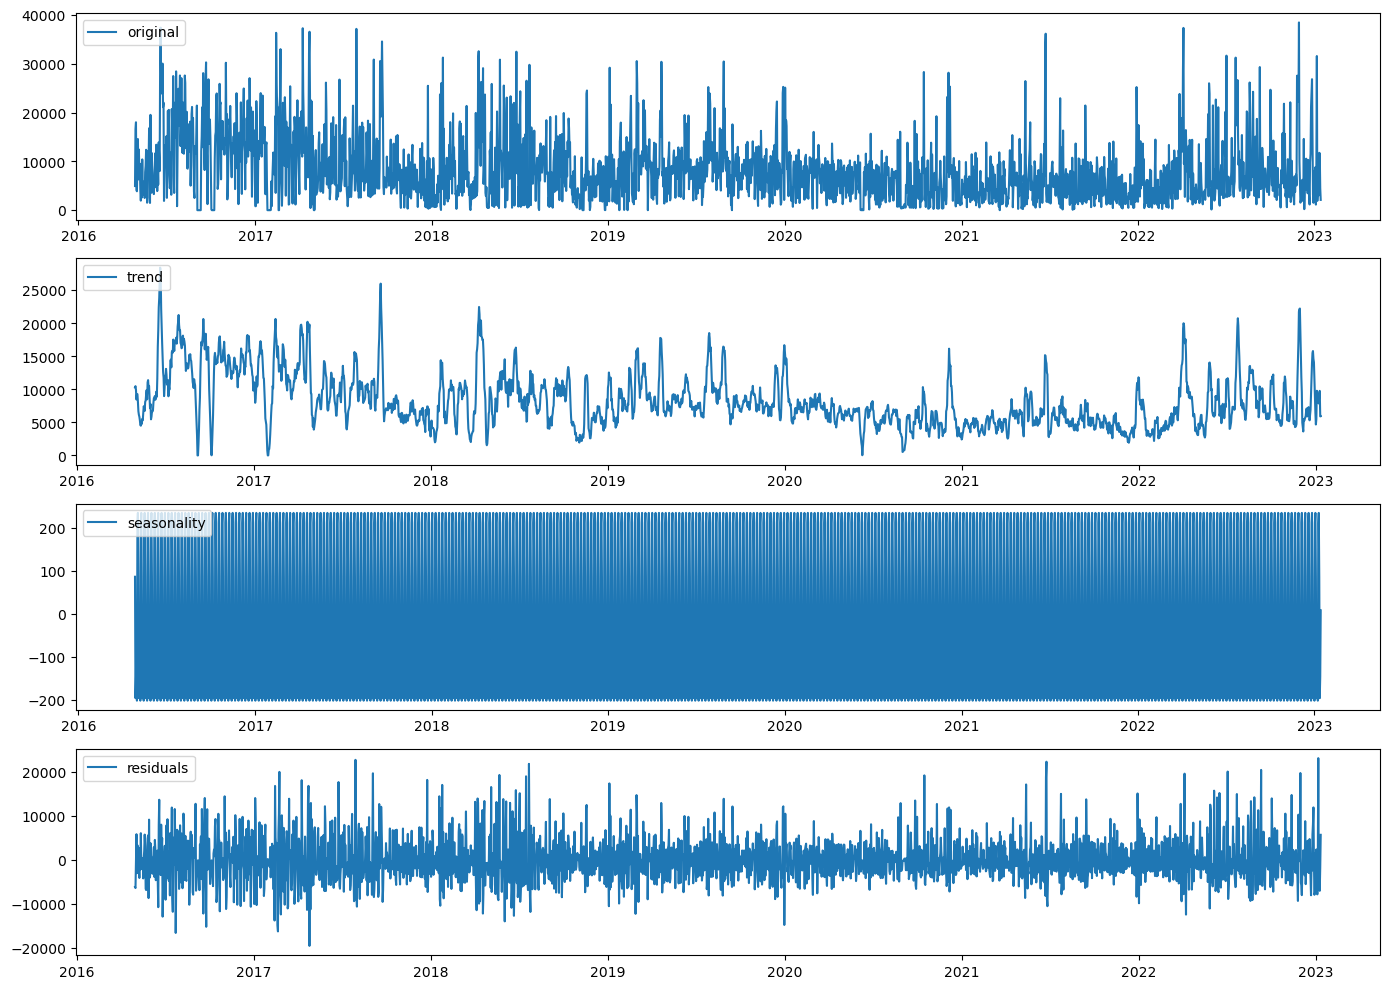

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['steps'], model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(df['steps'], label='original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Prophet analysis 

In [41]:
pip install prophet

In [42]:
from prophet import Prophet

In [45]:
df_prophet = df[['steps']].reset_index().rename(columns={'date': 'ds', 'steps': 'y'})

In [47]:
model = Prophet()
model.fit(df_prophet)

17:26:35 - cmdstanpy - INFO - Chain [1] start processing
17:26:36 - cmdstanpy - INFO - Chain [1] done processing


In [49]:
future = model.make_future_dataframe(periods=len(df) // 5)

In [51]:
forecast = model.predict(future)

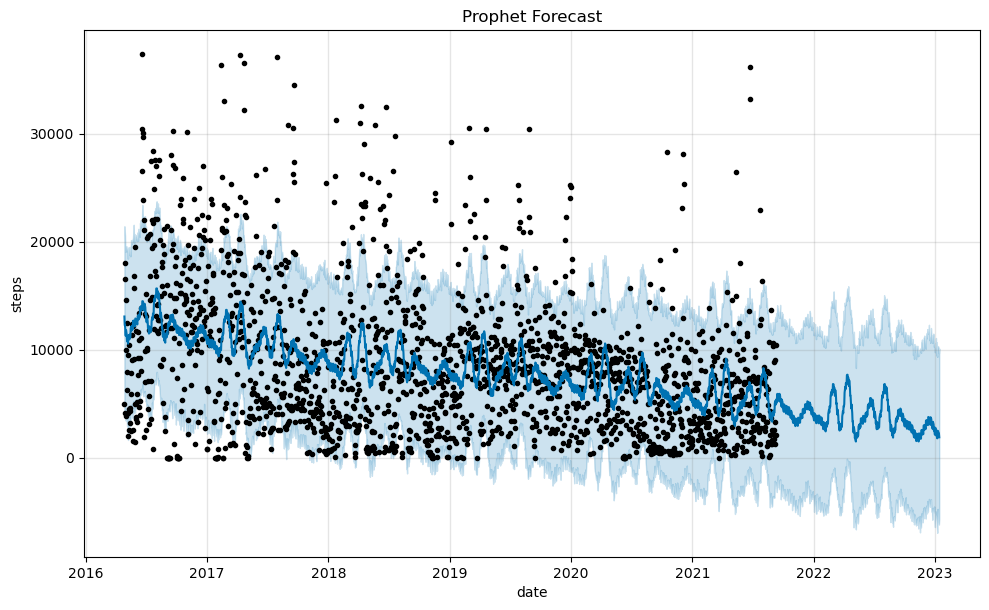

In [83]:
fig1 = model.plot(forecast)
plt.title('Prophet Forecast')
plt.xlabel('date')
plt.ylabel('steps')
plt.show()

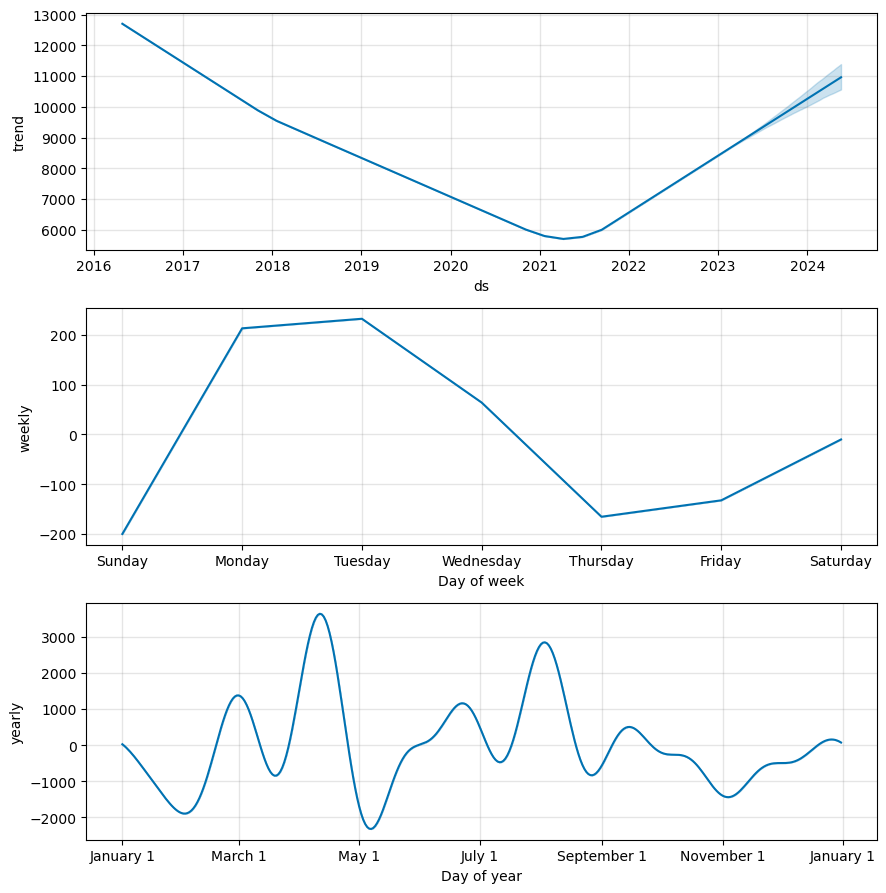

In [55]:
fig2 = model.plot_components(forecast)
plt.show()

### Model Evaluation

In [85]:
train_size = int(len(df) * 0.8)
train = df_prophet[:train_size]
test = df_prophet[train_size:]

In [87]:
model = Prophet()
model.fit(train)

17:34:18 - cmdstanpy - INFO - Chain [1] start processing
17:34:18 - cmdstanpy - INFO - Chain [1] done processing


In [88]:
future = model.make_future_dataframe(periods=len(test))

forecast = model.predict(future)

forecast_test = forecast.iloc[-len(test):]

In [89]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [91]:
y_true = test['y'].values
y_pred = forecast_test['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 4685.335079300138
Mean Squared Error (MSE): 53998469.952084705
Root Mean Squared Error (RMSE): 7348.365121037788


In [104]:
Q1 = df['steps'].quantile(0.25)
Q3 = df['steps'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [114]:
df_no_outliers = df[(df['steps'] >= lower_bound) & (df['steps'] <= upper_bound)]

In [116]:
print(df_no_outliers.columns)
print(df_no_outliers.head())

Index(['steps', 'distance', 'rundistance', 'calories'], dtype='object')
            steps  distance  rundistance  calories
date                                              
2016-04-27   4948      3242           46       281
2016-04-28  16573     12060           79       751
2016-04-29  18002     12916           29       737
2016-04-30   4126      2981           11       207
2016-05-01   3869      2651            0       244


In [118]:
df_no_outliers.reset_index(inplace=True)

In [120]:
df_prophet_no_outliers = df_no_outliers[['date', 'steps']].rename(columns={'date': 'ds', 'steps': 'y'})

In [122]:
train_size = int(len(df_no_outliers) * 0.8)
train_no_outliers = df_prophet_no_outliers[:train_size]
test_no_outliers = df_prophet_no_outliers[train_size:]

In [124]:
model_no_outliers = Prophet()
model_no_outliers.fit(train_no_outliers)

17:38:56 - cmdstanpy - INFO - Chain [1] start processing
17:38:56 - cmdstanpy - INFO - Chain [1] done processing


In [126]:
future_no_outliers = model_no_outliers.make_future_dataframe(periods=len(test_no_outliers))

In [128]:
forecast_no_outliers = model_no_outliers.predict(future_no_outliers)

In [130]:
forecast_test_no_outliers = forecast_no_outliers.iloc[-len(test_no_outliers):]

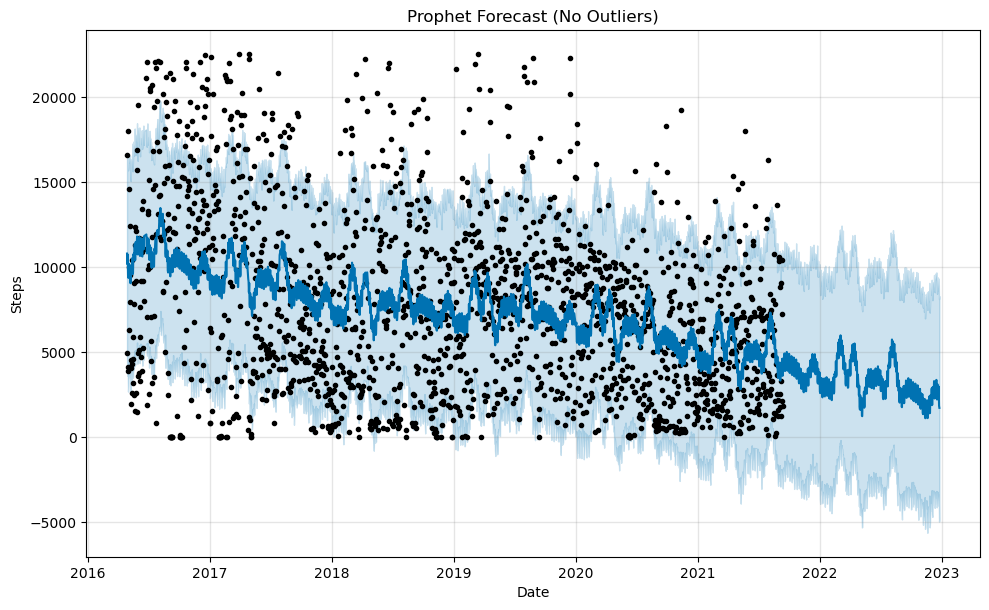

In [132]:
fig1_no_outliers = model_no_outliers.plot(forecast_no_outliers)
plt.title('Prophet Forecast (No Outliers)')
plt.xlabel('Date')
plt.ylabel('Steps')
plt.show()

In [134]:
y_true_no_outliers = test_no_outliers['y'].values
y_pred_no_outliers = forecast_test_no_outliers['yhat'].values

mae_no_outliers = mean_absolute_error(y_true_no_outliers, y_pred_no_outliers)
mse_no_outliers = mean_squared_error(y_true_no_outliers, y_pred_no_outliers)
rmse_no_outliers = np.sqrt(mse_no_outliers)

print(f'Mean Absolute Error (MAE): {mae_no_outliers}')
print(f'Mean Squared Error (MSE): {mse_no_outliers}')
print(f'Root Mean Squared Error (RMSE): {rmse_no_outliers}')

Mean Absolute Error (MAE): 4039.281265889333
Mean Squared Error (MSE): 32805740.11066888
Root Mean Squared Error (RMSE): 5727.629536786478


In [136]:
analysis_text = f"""
### Time Series Analysis and Forecasting

**Mean Absolute Error (MAE):** {mae_no_outliers:.2f}
**Mean Squared Error (MSE):** {mse_no_outliers:.2f}
**Root Mean Squared Error (RMSE):** {rmse_no_outliers:.2f}

The Prophet model was used to forecast the daily steps after removing outliers from the dataset. 
The performance metrics indicate an improvement in model accuracy after outlier removal.
The forecast plot and the calculated metrics provide insights into the model's performance and its predictive accuracy.
"""

print(analysis_text)


### Time Series Analysis and Forecasting

**Mean Absolute Error (MAE):** 4039.28
**Mean Squared Error (MSE):** 32805740.11
**Root Mean Squared Error (RMSE):** 5727.63

The Prophet model was used to forecast the daily steps after removing outliers from the dataset. 
The performance metrics indicate an improvement in model accuracy after outlier removal.
The forecast plot and the calculated metrics provide insights into the model's performance and its predictive accuracy.

